In [1]:
BASE_PATH = "/content/drive/MyDrive/Académico/UNIR/MUQC/99 - TFM/dev"

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import random
import time
import pandas as pd
# usaremos "from pennylane import numpy as np" tras la instalación de PennyLane para el uso de los métodos de diferenciación automática
#import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf

In [4]:
!pip install pennylane

In [5]:
!pip install cuquantum

In [6]:
!pip install pennylane-lightning[gpu]

In [7]:
from pennylane import numpy as np

In [8]:
N_QUBITS = 8

In [9]:
RANDOM_SEED = 1234

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
#tf.random.set_seed(RANDOM_SEED)

In [10]:
PCA_COMPONENTS = 8

In [11]:
df_tr_day_syn_resampled = pd.read_csv(BASE_PATH + "/dataset/tr_day_syn_small.csv")

In [12]:
df_test_day_syn_resampled = pd.read_csv(BASE_PATH + "/dataset/test_day_syn_small.csv")

In [13]:
x_tr = df_tr_day_syn_resampled.drop(columns = " Label").to_numpy()

In [14]:
y_tr = df_tr_day_syn_resampled[" Label"].to_numpy()

In [15]:
x_test = df_test_day_syn_resampled.drop(columns = " Label").to_numpy()

In [16]:
y_test = df_test_day_syn_resampled[" Label"].to_numpy()

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size = 0.5, stratify = y_test)

In [19]:
from sklearn.preprocessing import MaxAbsScaler

In [20]:
scaler = MaxAbsScaler()
x_tr = scaler.fit_transform(x_tr)

x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [21]:
x_test = np.clip(x_test, 0, 1)
x_val = np.clip(x_val, 0, 1)

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(n_components = PCA_COMPONENTS)

In [24]:
start = time.time()

xs_tr = pca.fit_transform(x_tr)
xs_test = pca.transform(x_test)
xs_val = pca.transform(x_val)

end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 0.03129982948303223 s


In [25]:
import pennylane as qml

In [26]:
dev = qml.device("lightning.gpu", wires = N_QUBITS)

In [27]:
@qml.qnode(dev)
def kernel_circ(a, b):
  qml.AngleEmbedding(a, wires = range(N_QUBITS))
  qml.adjoint(qml.AngleEmbedding(b, wires = range(N_QUBITS)))
  return qml.probs(wires = range(N_QUBITS))

(<Figure size 500x900 with 1 Axes>, <Axes: >)


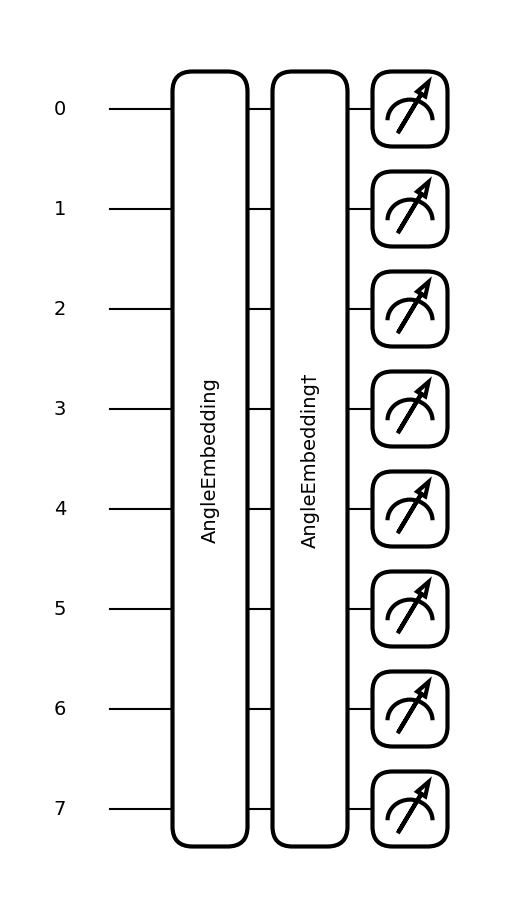

In [28]:
print(qml.draw_mpl(kernel_circ)(xs_tr[0], xs_tr[0]))

In [29]:
def qkernel(A, B):
  return np.array([[kernel_circ(a, b)[0] for b in B] for a in A])

In [30]:
from sklearn import svm

model = svm.SVC(kernel = qkernel)

In [31]:
start = time.time()

In [32]:
model.fit(xs_tr, y_tr)

SVC(kernel=<function qkernel at 0x7c40ff7d1cf0>)

In [33]:
end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 1265.5877163410187 s


In [34]:
from sklearn.metrics import accuracy_score

start = time.time()

tr_acc = accuracy_score(model.predict(xs_tr) >= 0.5, y_tr)
val_acc = accuracy_score(model.predict(xs_val) >= 0.5, y_val)
test_acc = accuracy_score(model.predict(xs_test) >= 0.5, y_test)

end = time.time()
print(f"Elapsed time: {end - start} s")

Elapsed time: 1576.2830700874329 s


In [35]:
print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)

Train accuracy: 0.99875
Validation accuracy: 1.0
Test accuracy: 0.99


In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
output = model.predict(xs_test)
result = (output > 0.5).astype(float)

In [38]:
confusion_matrix(y_true = y_test, y_pred = result)

array([[89,  1],
       [ 0, 10]])

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_test, y_pred = result))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        90
           1       0.91      1.00      0.95        10

    accuracy                           0.99       100
   macro avg       0.95      0.99      0.97       100
weighted avg       0.99      0.99      0.99       100



In [40]:
from sklearn.metrics import roc_curve

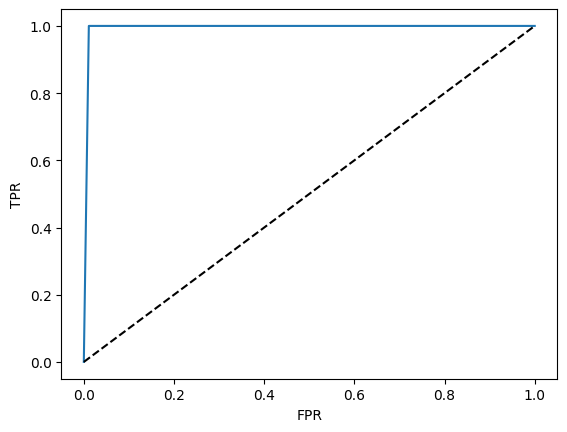

In [41]:
fpr, tpr, _ = roc_curve(y_test, output)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle = "--", color = "black")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

In [42]:
from sklearn.metrics import auc

print(auc(fpr, tpr))

0.9944444444444445
